In [1017]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import roc_curve, auc

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [1018]:
# Split data into training/validation and test sets based on dates
start_date = '1992-01-31'
end_date = '2018-07-20'

In [1019]:
stock_name = 'XRM'

# Technical Analysis
file_path_1 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_CRSP_daily_data_alltime.csv' # Daily data (CRSP)

# Fundamental Analysis
file_path_2 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_Compustat_q_data_alltime.csv' # Fundamentals (Compustat)
file_path_3 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_Compustat_quarterly_ratiodata_alltime.csv' # Ratios (Compustat)

In [1020]:
df2 = pd.read_csv(file_path_2)
df3 = pd.read_csv(file_path_3)
df2['datadate'] = pd.to_datetime(df2['datadate'])  # Fundamental data
df3['qdate'] = pd.to_datetime(df3['qdate'])  # Financial ratios data

# Make a copy of df2 to avoid modifying the original data
df2_pct = df2.copy()

# Identify numeric columns that should be converted to percentage changes
# Exclude non-numeric columns such as 'gvkey', 'datadate', 'fyearq', 'fqtr', 'indfmt', 'consol', 'popsrc', 'datafmt', 'tic', 'curcdq', 'datacqtr', 'datafqtr', 'costat'
columns_to_change = ['epsfxq', 'ltq', 'niq', 'revtq', 'capxy']
# Apply pct_change to each selected column and multiply by 100 to express as percentage
df2_pct[columns_to_change] = df2[columns_to_change].pct_change() * 100

# Sort by qdate and public_date to ensure the most recent public_date comes last
df3 = df3.sort_values(by=['qdate', 'public_date'])
# Drop duplicates to keep only the latest public_date for each qdate
df3 = df3.drop_duplicates(subset='qdate', keep='last')

# Make a copy to avoid modifying the original df3_latest
df3_pct = df3.copy()

# Select columns to calculate percentage change, excluding identifier and date columns
columns_to_change = ['npm', 'de_ratio', 'curr_ratio', 'ptb'] # Apply pct_change to each selected column and multiply by 100 to express as percentage
df3_pct[columns_to_change] = df3[columns_to_change].pct_change() * 100

df_fundamental = pd.merge_asof(
    df2,  # Daily data sorted by date
    df3,  # Fundamental data sorted by quarterly date
    left_on='datadate', right_on='qdate',  # Merge on dates
    direction='backward'  # Merge to the closest past quarter
)

fundamentals = [ 'epsfxq', 'ltq', 'niq', 'revtq', 'capxy', 'npm']
ratios = ['de_ratio', 'curr_ratio', 'ptb']

column_renames = {
    'epsfxq': 'earnings_per_share', 
    'ltq': 'long_term_debt', 
    'niq': 'net_income', 
    'revtq': 'revenue', 
    'capxy': 'capital_expenditure', 
    'npm': 'net_profit_margin', 
    'de_ratio': 'debt_equity_ratio', 
    'curr_ratio': 'current_ratio', 
    'ptb': 'price_to_book_ratio'
}

df_fundamental[fundamentals] = df_fundamental[fundamentals].pct_change()
df_fundamental = df_fundamental[['datadate'] + fundamentals + ratios].rename(columns=column_renames)
df_fundamental = df_fundamental.dropna()
df_fundamental = df_fundamental[(df_fundamental['datadate'] >= start_date) & (df_fundamental['datadate'] <= end_date)].copy()
df_fundamental.index = range(len(df_fundamental))

df_fundamental.head()


datadate  earnings_per_share  long_term_debt  net_income   revenue  \
0 2002-03-31           -0.230769        0.036941   -0.220149 -0.078856   
1 2002-06-30            0.266667        0.049433    0.263158  0.172509   
2 2002-09-30            0.026316        0.022827    0.000000  0.069695   
3 2002-12-31            0.384615        0.006633    0.549242  0.041425   
4 2003-03-31            0.796296        0.101370    0.721271  0.100901   

   capital_expenditure  net_profit_margin  debt_equity_ratio  current_ratio  \
0            -0.757133          -0.135802              0.977          1.171   
1             1.169415          -0.114286              0.965          1.171   
2             0.547976          -0.048387              0.964          1.154   
3             0.403830           0.050847              1.009          1.154   
4            -0.743114           0.274194              1.007          1.158   

   price_to_book_ratio  
0                2.816  
1                2.459  
2                2.507  
3                2.586  
4                2.454

In [1021]:
df = pd.read_csv(file_path_1)

df['date'] = pd.to_datetime(df['date'])  # CRSP daily data
df = df[(df['date'] >= start_date) & (df['date'] <= end_date)].copy()
df.index = range(len(df))

df.head()

PERMNO       date TICKER  BIDLO  ASKHI    PRC         VOL        RET  \
0   11850 2002-01-31    XOM  38.30  39.05  39.05  11115000.0   0.009305   
1   11850 2002-02-01    XOM  38.80  39.20  39.00   9518300.0  -0.001280   
2   11850 2002-02-04    XOM  38.26  39.20  38.35  10086100.0  -0.016667   
3   11850 2002-02-05    XOM  37.85  38.90  38.33  10948500.0  -0.000521   
4   11850 2002-02-06    XOM  38.13  38.98  38.92  10385700.0   0.015393   

   OPENPRC  
0    38.51  
1    39.15  
2    39.10  
3    38.60  
4    38.34

In [1022]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.date,
                      open=df.OPENPRC,
                      high=df.ASKHI,
                      low=df.BIDLO,
                      close=df.PRC,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.date, y=df.VOL, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

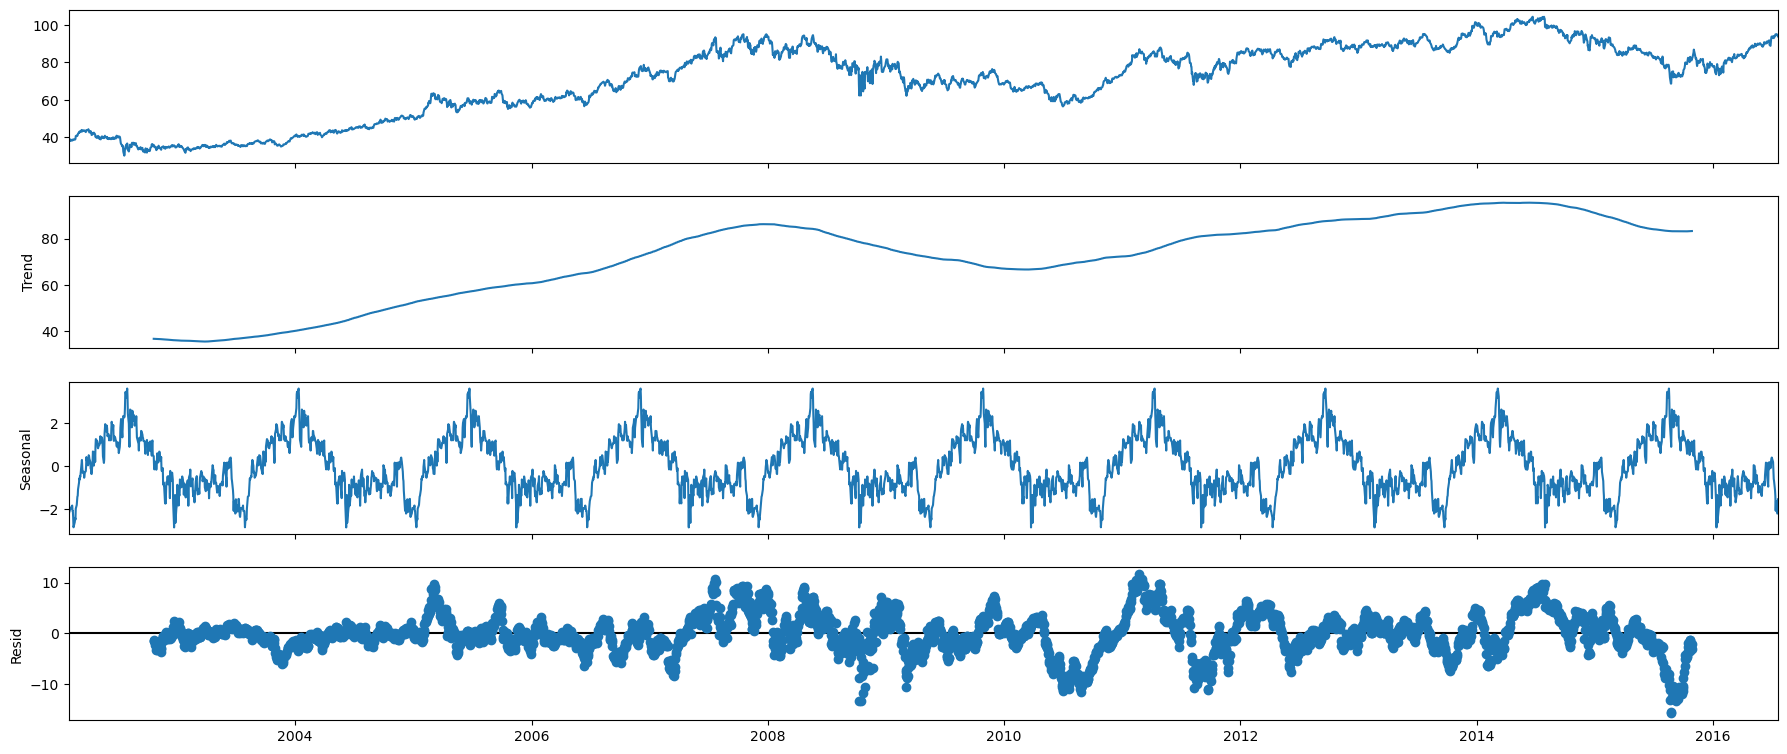

In [1023]:
df_close = df[['date', 'PRC']].copy()
df_close = df_close.set_index('date')
df_close.head()

decomp = seasonal_decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)

In [1024]:
df['EMA_30'] = df['PRC'].ewm(30).mean().shift()
df['SMA_5'] = df['PRC'].rolling(5).mean().shift()
df['SMA_15'] = df['PRC'].rolling(15).mean().shift()
df['SMA_30'] = df['PRC'].rolling(30).mean().shift()
df['SMA_60'] = df['PRC'].rolling(60).mean().shift()
df['SMA_90'] = df['PRC'].rolling(90).mean().shift()
df['SMA_120'] = df['PRC'].rolling(120).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.EMA_30, name='EMA 30'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_60, name='SMA 60'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_90, name='SMA 90'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_120, name='SMA 20'))
fig.add_trace(go.Scatter(x=df.date, y=df.PRC, name='PRC', opacity=0.2))
fig.show()

In [1025]:
def relative_strength_idx(df, n=14):
    close = df['PRC']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.date, y=df.RSI, name='RSI'))
fig.show()

In [1026]:
EMA_12 = pd.Series(df['PRC'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['PRC'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.date, y=df.PRC, name='PRC'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [1027]:
def calculate_adx(df, period=14):
    """
    Adds the ADX (Average Directional Index) column to a given DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'ASKHI', 'BIDLO', and 'PRC' columns.
        period (int): The lookback period for ADX calculation (default is 14).

    Returns:
        pd.DataFrame: DataFrame with an additional 'ADX' column (values between 0-100).
    """
    # Compute True Range (TR)
    df['High-Low'] = df['ASKHI'] - df['BIDLO']
    df['High-Close'] = abs(df['ASKHI'] - df['PRC'].shift(1))
    df['Low-Close'] = abs(df['BIDLO'] - df['PRC'].shift(1))
    df['TR'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)

    # Compute Directional Movement (+DM and -DM)
    df['+DM'] = np.where((df['ASKHI'].diff() > df['BIDLO'].diff()) & (df['ASKHI'].diff() > 0), df['ASKHI'].diff(), 0)
    df['-DM'] = np.where((df['BIDLO'].diff() > df['ASKHI'].diff()) & (df['BIDLO'].diff() > 0), df['BIDLO'].diff(), 0)

    # Compute smoothed values using Wilder's smoothing (EMA-like smoothing)
    df['Smooth TR'] = df['TR'].rolling(window=period).mean()
    df['Smooth +DM'] = df['+DM'].rolling(window=period).mean()
    df['Smooth -DM'] = df['-DM'].rolling(window=period).mean()

    # Compute +DI and -DI as percentages (THIS FIXES SCALING ISSUES)
    df['+DI'] = (df['Smooth +DM'] / df['Smooth TR']) * 100
    df['-DI'] = (df['Smooth -DM'] / df['Smooth TR']) * 100

    # Compute DX (Directional Index)
    df['DX'] = (abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])) * 100

    # Compute ADX (Average of DX over the period) using Rolling Mean
    df['ADX'] = df['DX'].rolling(window=period).mean()

    # Ensure ADX is properly constrained to 0-100
    df['ADX'] = df['ADX'].clip(lower=0, upper=100)

    # Drop unnecessary intermediate columns
    df.drop(columns=['High-Low', 'High-Close', 'Low-Close', '+DM', '-DM', 'Smooth TR', 'Smooth +DM', 'Smooth -DM', 'DX'], inplace=True)

    return df

# Example Usage:
# df = pd.read_csv('your_stock_data.csv')  # Ensure your data has 'ASKHI', 'BIDLO', 'PRC' columns
# df = calculate_adx(df)


df = calculate_adx(df)
df = df.dropna()


In [1028]:
df.index = range(len(df))  # Reset index
print(df.isna().sum().sum())

df.head(10)

0


PERMNO       date TICKER   BIDLO   ASKHI    PRC         VOL        RET  \
0   11850 2002-07-24    XOM  30.500  34.150  33.93  39491200.0   0.097348   
1   11850 2002-07-25    XOM  33.091  34.700  33.90  26839400.0  -0.000884   
2   11850 2002-07-26    XOM  33.750  35.200  35.09  15832500.0   0.035103   
3   11850 2002-07-29    XOM  35.340  36.449  36.33  16119300.0   0.035338   
4   11850 2002-07-30    XOM  35.200  36.370  35.67  17287600.0  -0.018167   
5   11850 2002-07-31    XOM  35.250  36.880  36.76  18178800.0   0.030558   
6   11850 2002-08-01    XOM  33.510  35.790  33.65  21654000.0  -0.084603   
7   11850 2002-08-02    XOM  32.800  34.250  33.61  16048500.0  -0.001189   
8   11850 2002-08-05    XOM  32.320  34.240  32.50  12727000.0  -0.033026   
9   11850 2002-08-06    XOM  33.070  34.250  33.40  13247400.0   0.027692   

   OPENPRC     EMA_30  ...     SMA_60     SMA_90    SMA_120        RSI  \
0    30.90  38.589640  ...  38.987500  40.232667  40.301667  30.508475   
1    33.94  38.436430  ...  38.891333  40.125111  40.259000  27.574526   
2    34.00  38.287365  ...  38.786833  40.015778  40.216500  33.312223   
3    35.90  38.182363  ...  38.693500  39.919000  40.189333  39.465695   
4    36.37  38.121567  ...  38.619000  39.839000  40.172667  41.773779   
5    35.52  38.041150  ...  38.537000  39.751667  40.145583  48.904639   
6    35.25  37.999148  ...  38.495500  39.677111  40.132750  42.026578   
7    33.85  37.856638  ...  38.404667  39.574889  40.094083  43.822171   
8    33.65  37.717558  ...  38.298000  39.462333  40.053333  42.449664   
9    33.15  37.546764  ...  38.183667  39.335111  40.004167  43.984758   

       MACD  MACD_signal     TR        +DI        -DI        ADX  
0 -1.986522    -1.374934  3.650  11.408340   8.693942  49.096351  
1 -1.898705    -1.479688  1.609  11.027035  17.609035  48.795279  
2 -1.713342    -1.526419  1.450  10.634787  18.042466  48.027125  
3 -1.449679    -1.511071  1.359  10.432405  23.418951  48.762853  
4 -1.279231    -1.464703  1.170  10.985681  24.660959  49.498582  
5 -1.044165    -1.380596  1.630  12.825335  24.484730  50.749005  
6 -1.096175    -1.323711  3.250  11.948980  22.811690  51.999428  
7 -1.127622    -1.284493  1.450  12.478044  23.821721  54.077961  
8 -1.227952    -1.273185  1.920  12.253845  21.057927  51.958803  
9 -1.220773    -1.262703  1.750  12.012118  20.536847  48.958274  

[10 rows x 23 columns]

In [1029]:
horizon = 30

# Define the target variable directly
df['target'] = (df['PRC'].shift(-horizon) > df['PRC']).astype(int)

# Drop NaNs resulting from the shift
df = df.dropna()
df.index = range(len(df))  # Reset index

df.tail()

#print(len(df))


PERMNO       date TICKER  BIDLO    ASKHI    PRC         VOL        RET  \
3518   11850 2016-07-14    XOM  94.62  95.5300  94.95   9293450.0   0.000738   
3519   11850 2016-07-15    XOM  94.64  95.5500  95.12  10334453.0   0.001790   
3520   11850 2016-07-18    XOM  94.40  95.1500  94.82   9865850.0  -0.003154   
3521   11850 2016-07-19    XOM  94.20  94.9400  94.47   5901792.0  -0.003691   
3522   11850 2016-07-20    XOM  93.80  94.4161  93.93   7383789.0  -0.005716   

      OPENPRC     EMA_30  ...     SMA_90    SMA_120        RSI      MACD  \
3518    95.05  89.841777  ...  87.918444  85.886833  62.050497  1.274201   
3519    95.44  90.006559  ...  88.035000  86.040000  76.454294  1.302555   
3520    94.92  90.171508  ...  88.173778  86.216167  78.113208  1.285994   
3521    94.76  90.321460  ...  88.311778  86.367167  70.000000  1.230443   
3522    94.25  90.455284  ...  88.448333  86.527000  59.315589  1.129822   

      MACD_signal    TR        +DI        -DI        ADX  target  
3518     1.067251  0.91  27.976984  16.206331  13.953028       0  
3519     1.114312  0.91  30.617281  17.735786  14.149999       0  
3520     1.148648  0.75  31.523457  18.260709  11.868614       0  
3521     1.165007  0.74  23.013398  19.725770  12.042125       0  
3522     1.157970  0.67  13.229995  21.155053  12.369028       0  

[5 rows x 24 columns]

In [1030]:
# Add fundamental data
'''
df = pd.merge_asof(
    df,  # Daily data sorted by date
    df_fundamental,  # Fundamental data sorted by quarterly date
    left_on='date', right_on='datadate',  # Merge on dates
    direction='backward'  # Merge to the closest past quarter
)

df = df.drop('datadate', 1)
df.head()

'''

"\ndf = pd.merge_asof(\n    df,  # Daily data sorted by date\n    df_fundamental,  # Fundamental data sorted by quarterly date\n    left_on='date', right_on='datadate',  # Merge on dates\n    direction='backward'  # Merge to the closest past quarter\n)\n\ndf = df.drop('datadate', 1)\ndf.head()\n\n"

In [1031]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

#Ony keep the last day of each month
#test_df = test_df.loc[df.groupby(test_df['date'].dt.to_period('M'))['date'].idxmax()]
#test_df['target'] = (test_df['PRC'].shift(-1) > test_df['PRC']).astype(int)

df.head(10)

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.date, y=train_df.PRC, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.date, y=valid_df.PRC, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.date,  y=test_df.PRC,  name='Test'))
fig.show()

# save test dates
test_dates = test_df['date']

In [1032]:
drop_cols = ['date', 'VOL', 'BIDLO', 'ASKHI', 'RET', 'OPENPRC', 'TICKER', 'PERMNO']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

train_df.head()

PRC     EMA_30   SMA_5     SMA_15     SMA_30     SMA_60     SMA_90  \
0  33.93  38.589640  32.790  36.500667  38.131333  38.987500  40.232667   
1  33.90  38.436430  32.454  36.085333  37.961333  38.891333  40.125111   
2  35.09  38.287365  32.284  35.684667  37.768000  38.786833  40.015778   
3  36.33  38.182363  32.822  35.322667  37.625667  38.693500  39.919000   
4  35.67  38.121567  34.034  35.054000  37.531667  38.619000  39.839000   

     SMA_120        RSI      MACD  MACD_signal     TR        +DI        -DI  \
0  40.301667  30.508475 -1.986522    -1.374934  3.650  11.408340   8.693942   
1  40.259000  27.574526 -1.898705    -1.479688  1.609  11.027035  17.609035   
2  40.216500  33.312223 -1.713342    -1.526419  1.450  10.634787  18.042466   
3  40.189333  39.465695 -1.449679    -1.511071  1.359  10.432405  23.418951   
4  40.172667  41.773779 -1.279231    -1.464703  1.170  10.985681  24.660959   

         ADX  target  
0  49.096351       0  
1  48.795279       1  
2  48.027125       0  
3  48.762853       0  
4  49.498582       0

In [1033]:
y_train = train_df['target'].copy()
X_train = train_df.drop(['target',], 1)

y_valid = valid_df['target'].copy()
X_valid = valid_df.drop(['target',], 1)

y_test  = test_df['target'].copy()
X_test  = test_df.drop(['target',], 1)

X_train.head()

PRC     EMA_30   SMA_5     SMA_15     SMA_30     SMA_60     SMA_90  \
0  33.93  38.589640  32.790  36.500667  38.131333  38.987500  40.232667   
1  33.90  38.436430  32.454  36.085333  37.961333  38.891333  40.125111   
2  35.09  38.287365  32.284  35.684667  37.768000  38.786833  40.015778   
3  36.33  38.182363  32.822  35.322667  37.625667  38.693500  39.919000   
4  35.67  38.121567  34.034  35.054000  37.531667  38.619000  39.839000   

     SMA_120        RSI      MACD  MACD_signal     TR        +DI        -DI  \
0  40.301667  30.508475 -1.986522    -1.374934  3.650  11.408340   8.693942   
1  40.259000  27.574526 -1.898705    -1.479688  1.609  11.027035  17.609035   
2  40.216500  33.312223 -1.713342    -1.526419  1.450  10.634787  18.042466   
3  40.189333  39.465695 -1.449679    -1.511071  1.359  10.432405  23.418951   
4  40.172667  41.773779 -1.279231    -1.464703  1.170  10.985681  24.660959   

         ADX  
0  49.096351  
1  48.795279  
2  48.027125  
3  48.762853  
4  49.498582

In [1034]:
# Scaling
scaler = MinMaxScaler()

# Fit the scaler on the training/validation data
X_train_scaled = scaler.fit_transform(X_train)

# Now apply the same scaling to the val/test data using the already fitted scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled.head(90)

PRC    EMA_30     SMA_5    SMA_15    SMA_30    SMA_60    SMA_90  \
0   0.033370  0.077590  0.008123  0.060508  0.079291  0.086120  0.102814   
1   0.032896  0.074874  0.002729  0.053604  0.076413  0.084416  0.100898   
2   0.051716  0.072232  0.000000  0.046944  0.073141  0.082564  0.098950   
3   0.071327  0.070371  0.008636  0.040926  0.070731  0.080910  0.097225   
4   0.060889  0.069293  0.028093  0.036460  0.069140  0.079589  0.095800   
..       ...       ...       ...       ...       ...       ...       ...   
85  0.048078  0.009154  0.042829  0.028281  0.022819  0.000821  0.000303   
86  0.037957  0.009229  0.043985  0.029611  0.023423  0.000597  0.000154   
87  0.043966  0.008936  0.041962  0.029124  0.023242  0.000251  0.000049   
88  0.033845  0.008869  0.040774  0.029500  0.023056  0.000000  0.000485   
89  0.049660  0.008438  0.036793  0.027705  0.021736  0.000100  0.001216   

     SMA_120       RSI      MACD  MACD_signal        TR       +DI       -DI  \
0   0.108862  0.254977  0.230933     0.277126  0.306195  0.251978  0.203616   
1   0.108087  0.221563  0.245306     0.257517  0.125575  0.243556  0.415443   
2   0.107314  0.286909  0.275645     0.248770  0.111504  0.234892  0.425741   
3   0.106820  0.356990  0.318798     0.251643  0.103451  0.230422  0.553490   
4   0.106517  0.383276  0.346695     0.260322  0.086726  0.242642  0.583000   
..       ...       ...       ...          ...       ...       ...       ...   
85  0.024550  0.493911  0.577783     0.547924  0.053982  0.185839  0.477550   
86  0.023888  0.473691  0.569588     0.548330  0.054867  0.184748  0.422428   
87  0.023079  0.384264  0.567974     0.548286  0.055752  0.006871  0.447900   
88  0.022390  0.371171  0.558219     0.546020  0.052212  0.007206  0.469928   
89  0.021563  0.518630  0.563607     0.545439  0.077876  0.126419  0.471088   

         ADX  
0   0.530789  
1   0.527037  
2   0.517464  
3   0.526633  
4   0.535801  
..       ...  
85  0.144345  
86  0.138588  
87  0.220966  
88  0.305424  
89  0.353064  

[90 rows x 15 columns]

In [1035]:


%%time

parameters = {
    'n_estimators': [300],
    'learning_rate': [0.05],
    'max_depth': [8],
    'gamma': [0.00001],
    'random_state': [42]
}

eval_set = [(X_train_scaled, y_train), (X_valid_scaled, y_valid)]
model = xgb.XGBClassifier(eval_set=eval_set, objective='binary:logistic', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train_scaled, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')



/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[22:47:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[22:47:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[22:47:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[22:47:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[22:47:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { 

Best params: {'gamma': 1e-05, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
Best validation score = 0.3886779282423566
CPU times: user 26.1 s, sys: 1.15 s, total: 27.3 s
Wall time: 4.18 s


In [1036]:
%%time

model = xgb.XGBClassifier(**clf.best_params_, objective='binary:logistic')
model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)

CPU times: user 5.99 s, sys: 219 ms, total: 6.21 s
Wall time: 936 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1e-05, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

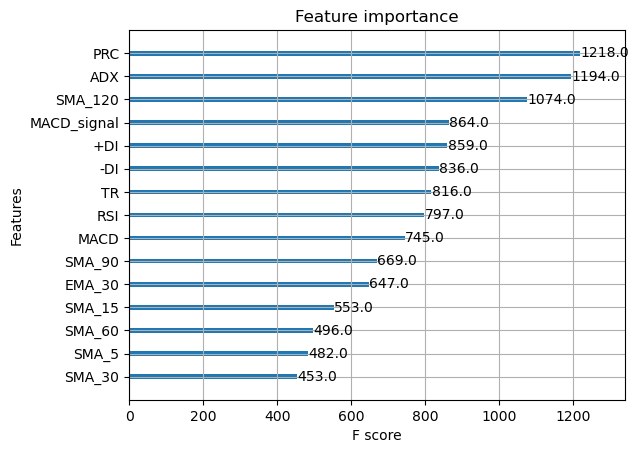

In [1037]:
plot_importance(model);

In [1038]:
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # Selecting only the positive class probability

test_df['y_pred'] = y_pred
test_df['y_pred_proba'] = y_pred_proba
test_df['date'] = test_dates

# Classification report
classification_report_data = classification_report(y_test, y_pred)
# Print the classification report
print(classification_report_data)


# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(roc_auc)

# Create interactive Plotly figure
fig = go.Figure()

# Add ROC curve
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (AUC = {roc_auc:.2f})',
                         line=dict(color='blue', width=2)))

# Add diagonal reference line
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Guess',
                         line=dict(color='gray', dash='dash')))

# Add "Ideal Classifier" line
fig.add_trace(go.Scatter(
    x=[0, 0, 1], y=[0, 1, 1], mode='lines', 
    name='Ideal Classifier',
    line=dict(color='green', dash='dash')
))

# Layout settings
fig.update_layout(title="Receiver Operating Characteristic (ROC) Curve",
                  xaxis_title="False Positive Rate",
                  yaxis_title="True Positive Rate",
                  xaxis=dict(range=[0,1]),
                  yaxis=dict(range=[0,1.05]),
                  template="plotly_white")

# Show interactive plot
fig.show()


#test_df.head()

              precision    recall  f1-score   support

           0       0.73      0.86      0.79       308
           1       0.74      0.55      0.63       220

    accuracy                           0.73       528
   macro avg       0.73      0.71      0.71       528
weighted avg       0.73      0.73      0.72       528

0.7842532467532468


In [1039]:
test_df_monthly = test_df.loc[df.groupby(test_df['date'].dt.to_period('M'))['date'].idxmax()]
buys = test_df_monthly[test_df_monthly['y_pred'] == 1]
sells = test_df_monthly[test_df_monthly['y_pred'] == 0]

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_df.date,  y=test_df.PRC,  name='Test'))

# Add Green Up Arrows for most certain class 1 predictions
fig.add_trace(go.Scatter(
    x=buys.date, 
    y=buys.PRC,
    mode='markers',
    marker=dict(color='green', size=15, symbol='triangle-up'),
))

# Add Red Down Arrows for most certain class 0 predictions
fig.add_trace(go.Scatter(
    x=sells.date, 
    y=sells.PRC,
    mode='markers',
    marker=dict(color='red', size=15, symbol='triangle-down'),
))

fig.update_layout(
    height=600  # Adjust height (default is ~450-500)
)

fig.show()
